# CNN + SIFT

In [33]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
import time

In [3]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=reverse)[:n] #Ordeno y me quedo con los 5 más parecidos
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("The value of n must be greater than 0.")
        return

    if n > len(sorted_indexes):
        print(f"There are only {len(sorted_indexes)} Images in the list. Showing all.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_folder, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(title)
        

    plt.show()
    
def get_images_path(folders, n_imgs):
    images_path = {}
    for folder in folders:
        for i in range(n_imgs):
            images_path[(folder[-7:], str(i))] = f'./dataset/{folder}/{folder[-9:]}_{str(i)}.JPEG'
    return images_path #Returns a dictionary where the key is (folder, id), and the values are the paths.

In [4]:
n_imgs = 100
folders = ["bus-n04487081", "nails-n03804744", "car-n02814533", "collar-n03814639", "plunger-n03970156",
           "cats-n02123394", "monkey-n02480495", "bridges-n04532670", "chair-n04099969", "dog-n02099601",
           "duck-n01855672", "pizza-n07873807", "sea-n09428293", "ipod-n03584254", "banana-n07753592", "gas_mask-n03424325",
           "bow_tie-n02883205", "fly-n02190166", "ice_cream-n07615774", "cannon-n02950826"]
len(folders)


20

In [5]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

In [6]:
if os.path.exists('./npy_mat/CNN_SIFT.npy'):
    cnn_sift = np.load('./npy_mat/CNN_SIFT.npy')
else:
    # Create a dictionary to map the unique combination of folder and index to features
    features_dict = {}
    for row in features:
        folder, index, *feature_values = row
        features_dict[(folder, index)] = feature_values

    # Create a list to store combined rows
    combined_data = []

    # Specify the batch size
    batch_size = 1000

    # Split 'descriptors' into smaller batches and combine them with 'features'
    for i in range(0, len(descriptors), batch_size):
        descriptors_batch = descriptors[i:i+batch_size]

        # Combine 'descriptors_batch' with 'features' and store in 'combined_data'
        for row in descriptors_batch:
            folder, index, *sift_descriptors = row
            if (folder, index) in features_dict:
                feature_values = features_dict[(folder, index)]
                combined_row = [folder, index] + feature_values + sift_descriptors
                combined_data.append(combined_row)

    # Convert the list of combined rows into a NumPy array
    cnn_sift = np.array(combined_data)
    np.save('CNN_SIFT', cnn_sift)


In [7]:
cnn_sift.shape

(72594, 25218)

In [34]:
n_neighbors = 20
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

# Remove the first two columns which correspond to the image indices
cnn_sift_train = cnn_sift[:, 2:]
knn.fit(cnn_sift_train)


NearestNeighbors(metric='euclidean', n_neighbors=20)

In [35]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
sift = cv2.SIFT_create()

# new_image_path = list(images_path.values())[random.randrange(0, len(folders)*n_imgs - 1)]
# new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
new_img = cv2.cvtColor(cv2.imread('./dataset/test/cars/n02814533_199.JPEG'), cv2.COLOR_BGR2RGB)

# Detect features and compute descriptors using SIFT
_, descriptors = sift.detectAndCompute(new_img, mask=None)

# Resize the image to the required size for the model
target_size = (224, 224)
new_img_cnn = cv2.resize(new_img, target_size)
# Add an extra dimension
new_img_cnn = np.expand_dims(new_img_cnn, axis=0)
# Normalize the image
new_img_cnn = preprocess_input(new_img_cnn)

# Extract image features using the CNN model
characteristics_img = model.predict(new_img_cnn)
characteristics_flat = characteristics_img.reshape(1, -1)

# Prepare to combine the CNN features with the SIFT descriptors
new_shape = (len(descriptors), 25088)
expanded_array = np.repeat(characteristics_flat, new_shape[0], axis=0)
full_arr = np.hstack((expanded_array, descriptors))


1/1 [==============================] - 1s 501ms/step


In [37]:
len(counts)

33

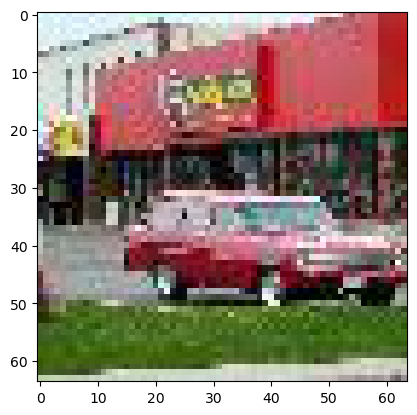

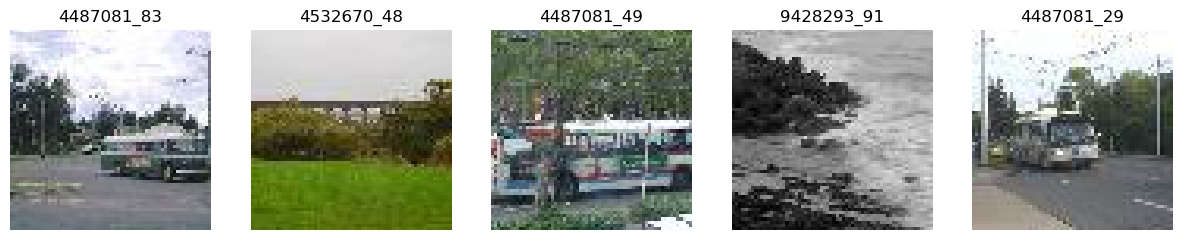

In [41]:
plt.imshow(new_img)
idx_similar = get_n_similar(n_neighbors, counts, 1)
display_n_similar(idx_similar, 5)